# 20 Simulated annealing homework

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo
from numba import njit

# Excercise 1

Consider the simulated annaling method from the lecture notes which found the global minimum of the function 
$$f(x) = \cos{x} + \cos{x\sqrt{2}} + \cos{x\sqrt{3}},$$
looking in the range $[0,50)$. 

We saw that the method didn't always work, and the method can become trapped in local minimum quite often.

- Adapt that program to find the global minimum 100 times. 
- Save each solution and make a historgram of the number of each solutions found during 100 trials of your simulation. 
- Did it find the correct global minimum very often? 

(This is a fairly long calculation to run the annealing 100 times.)

Change the method of choosing the step size to be drawn from a standard Cauchy distribution, then multiplied by the current temperature. Make a historgram of the solutions of 100 trials of your simulation. Did that help find  the solution more often? Why is that?

<font color="orange">Answer:</font>


<style>
p {
    font-size: 12pt
}
</style>

Using the Cauchy distribution to find the minimum is clearly the far superior method here, as can be seen in the plots. Why? Because the cauchy distrubution has thicker wings, which means we will get step sizes that are larger more often, allowing the simulation to find the minimum much more often, instead of getting stuck in a localc minimum as the temperature decreases/

In [2]:
@njit
def func(x):
    return np.cos(x)+np.cos(x*np.sqrt(2))+np.cos(x*np.sqrt(3))


@njit
def simulated_annealing_1D(mode="normal"):
    # The search range
    Xmin = 0
    Xmax = 50
    # The inital guess in the search range
    x = (Xmax-Xmin)*np.random.random()+Xmin

    Tmax = 10
    Tmin = 1e-6
    tau = 1e4
    T = Tmax
    t = 0.0

    while (T > Tmin):
        # Choose a random step
        if mode == "normal":
            dx = T*np.random.standard_normal()
        if mode == "cauchy":
            dx = T*np.random.standard_cauchy()
        if mode == "uniform":
            dx = T*np.random.uniform(-1, 1)

        # Test the new possible solution,
        # making sure to stay in the range [Xmin,Xmax].
        xp = x + dx
        if xp >= Xmin and xp <= Xmax:
            df = func(xp)-func(x)
            # If the 'energy' goes down, or the metropolis boltzman weight is
            # greater that number choose in [0,1), then
            # move the solution to the new point.
            if df < 0:
                x = xp
            elif np.random.random() < np.exp(-df/T):
                x = xp

        # Lower the temperature.
        t += 1
        T = Tmax*np.exp(-t/tau)
    # Return the best solution.
    return x


def plot_simulated_annealing(mode):
    iters = 100
    solutions = {}
    for i in range(iters):
        x = simulated_annealing_1D(mode=mode)
        key = round(x, 2)
        if key in solutions:
            solutions[key] += 1
        else:
            solutions[key] = 1
    hist = {
        "min = " + str(k): v
        for k, v in sorted(solutions.items())
    }

    bins = list(hist.keys())
    counts = list(hist.values())

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.bar(bins, counts)
    ax.set_title(f"Simulated Annealing (Mode: {mode})", fontsize=20)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Solution")
    ax.tick_params(axis="x", rotation=-90)
    plt.show()
    plt.close()


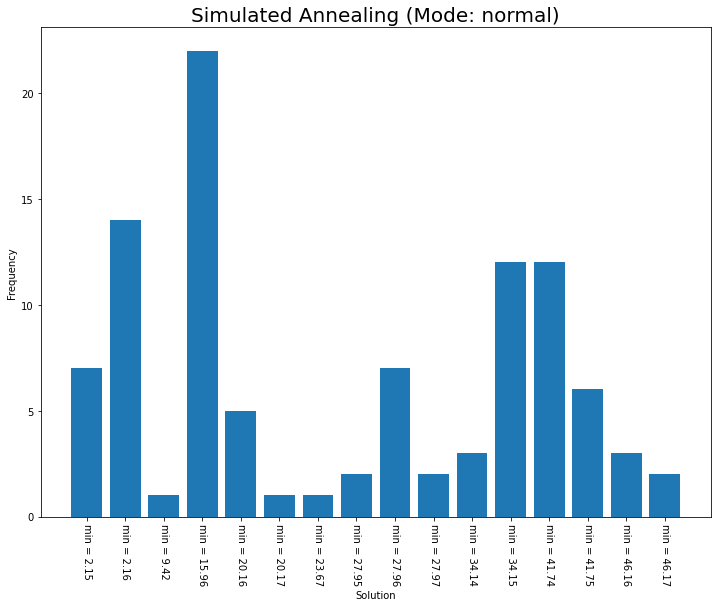

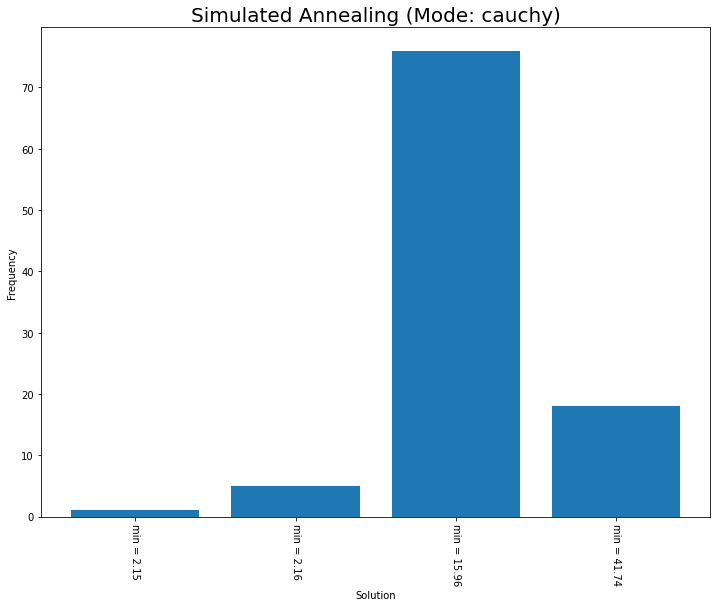

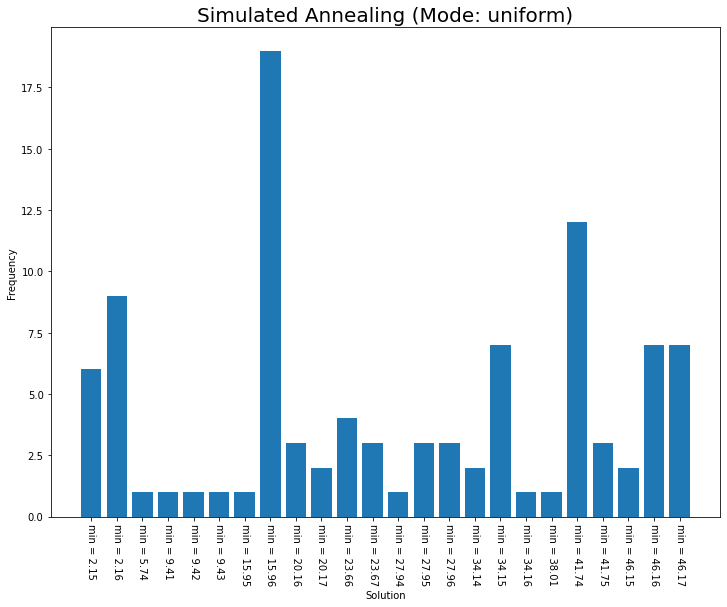

In [3]:
plot_simulated_annealing(mode="normal")
plot_simulated_annealing(mode="cauchy")
plot_simulated_annealing(mode="uniform")


# Excercise 2
Adapt the simluated annealing to solve the two dimensional <a href="https://en.wikipedia.org/wiki/Rosenbrock_function">Rosenbrock function</a> from an earlier assignment. Search in the range $[-50,50]$ for both dimensions. Which distribution will you use?

There is no need to keep track of many attempts. Just keep running the Jupyter cell manually until you see the correct answer appear.

<font color="orange">Answer:</font>


In [4]:
@njit
def rosenbrock(xy, a = 1, b = 100):
    x, y = xy
    return (a - x)**2 + b * (y - x**2)**2


@njit
def simulated_annealing(
    f,
    x0,
    xmin=-50.0,
    xmax=50.0,
    Tmax=1e4,
    Tmin=1e-6,
    tau=1e4,
    max_iters=1e3,
    mode="normal"
):
    # The inital guess in the search range
    x = x0
    shape = x.shape
    T = Tmax
    t = 0

    for i in range(max_iters):
        # If we reach the minimum temperature, return the best solution.
        if T < Tmin:
            return x, f(x), int(i)

        # Choose a random step
        if mode == "normal":
            dx = T * np.random.standard_normal(shape)
        if mode == "cauchy":
            dx = T * np.random.standard_cauchy(shape)
        if mode == "uniform":
            dx = T * np.random.uniform(-1,1, size=shape)

        # Test the new possible solution,
        # making sure to stay in the range [xmin, xmax].
        x_next = x + dx

        if np.all(x_next >= xmin) and np.all(x_next <= xmax):
            df = f(x_next) - f(x)
            # If the 'energy' goes down, or the metropolis boltzman weight is
            # greater that number choose in [0,1), then
            # move the solution to the new point.
            if df < 0:
                x = x_next
            elif np.random.random() < np.exp(-df/T):
                x = x_next

        # Lower the temperature.
        t += 1
        T = Tmax * np.exp(-t/tau)
    # Return the best solution.
    return x, f(x), int(max_iters)


In [5]:
xmin, xmax = -50, 50
x0 = (xmax-xmin)*np.random.random(2)+xmin
sol = simulated_annealing(
    rosenbrock,
    x0,
    xmin=xmin,
    xmax=xmax,
    tau=1e6,
    Tmin=1e-9,
    max_iters=1e9,
    mode="cauchy"
)
for i, val in enumerate(sol):
    if i == 0:
        print("x =", val)
    if i == 1:
        print("f(x) =", val)
    if i == 2:
        print("iters =", val)


x = [0.9999659  0.99993014]
f(x) = 1.442712414436305e-09
iters = 29933607


# Excercise 3
This time try to find the minimum of the <a href="http://www.sfu.ca/~ssurjano/egg.html">eggholder function.</a> Search in the range $[-512,+512]$, but start at $x=y=0$. This is a very long way form the minimum at $$f(x=512,y=404.2319)=-959.6407$$ You should raise the inital temperature quite a bit, and maybe increase the length $\tau$, to get the solution over the many minimums between your starting guess and the final solution.

<font color="orange">Answer</font>


In [6]:
@njit
def eggholder(x):
    x1, x2 = x
    return (
        -(x2+47) * np.sin(np.sqrt(abs(x2+x1/2+47))) -
        x1 * np.sin(np.sqrt(abs(x1-(x2+47))))
    )


In [7]:
xmin, xmax = -512, 512
x0 = np.array([0.0, 0.0])
sol = simulated_annealing(
    eggholder,
    x0,
    xmin=xmin,
    xmax=xmax,
    tau=1e5,
    Tmin=1e-9,
    Tmax=200,
    max_iters=1e8,
    mode="cauchy"
)
for i, val in enumerate(sol):
    if i == 0:
        print("x =", val)
    if i == 1:
        print("f(x) =", val)
    if i == 2:
        print("iters =", val)


x = [512.        404.2318464]
f(x) = -959.6406627185497
iters = 2602159


# Excercise 4

Try solving the eggholder function with `scipy.optimize.dual_annealing` with and without the option 
```python
no_local_search=True
```
Do you feel the `scipy` method worked better or worse than your program above?

<font color="orange">Answer</font>


<style>
p {
    font-size: 12pt
}
</style>

The scipy method of finding the minimum using dual_annealing is superior without a doubt when we include local searches. It is much faster, and much more reliable. However, without the option, my program does tend to find the true minimum more often, which may simply be a consquence of more finely tuned inital parameters.

In [8]:
print('Without local search')
sol1 = spo.dual_annealing(
    eggholder,
    bounds=[(-512,512), (-512,512)],
    maxiter=5_000,
    no_local_search=True,
    x0 = (0,0)
)
print(sol1)

print('\nWith local search')
sol2 = spo.dual_annealing(
    eggholder,
    bounds=[(-512,512), (-512,512)],
    maxiter=5_000,
    no_local_search=False,
    x0 = (0,0)
)
print(sol2)

Without local search
     fun: -956.8278203726933
 message: ['Maximum number of iteration reached']
    nfev: 20005
    nhev: 0
     nit: 5000
    njev: 0
  status: 0
 success: True
       x: array([483.04767797, 433.56959589])

With local search
     fun: -935.33795156058
 message: ['Maximum number of iteration reached']
    nfev: 46942
    nhev: 0
     nit: 5000
    njev: 8979
  status: 0
 success: True
       x: array([439.48099843, 453.97743556])


# Excercise 5

Use `scipy.optimize.differential_evolution` to solve the eggholder problem. You may need to increase the maximum number of iterations, and the population size to get semi-consistent results.

<font color="orange">Answer</font>


<style>
p {
    font-size: 12pt
}
</style>

I was unable to get this to be consistent whatever I tried.

In [28]:
sol = spo.differential_evolution(
    eggholder,
    bounds=[(-512,512), (-512,512)],
    strategy="best1exp",
    maxiter=20000,
    popsize=3000,
    tol=0.001,
    mutation=(0,0),
    updating="deferred",
    workers=20
)
print(sol)

     fun: -959.6406627208435
     jac: array([-3.38555724e+00, -2.27373495e-05])
 message: 'Optimization terminated successfully.'
    nfev: 84030
     nit: 13
 success: True
       x: array([512.        , 404.23180258])
